In [1]:
import mxnet as mx
import gluoncv as gcv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Ctx 
ctx = [mx.gpu(i) for i in range(mx.context.num_gpus())] if mx.context.num_gpus()>0 else [mx.cpu()] #for the purpose of this tutorial we will use the cpu

In [3]:
#Datasets
train = gcv.data.RecordFileDetection('./data/train.rec',coord_normalized=False)
val = gcv.data.RecordFileDetection('./data/val.rec',coord_normalized=False)

In [4]:
#The following are the class names given on this dataset

In [5]:
classes = ['Passenger Vehicle',
'Small Car',
'Bus',
'Pickup Truck',
'Utility Truck',
'Truck',
'Cargo Truck',
'Truck Tractor w/ Box Trailer',
'Truck Tractor',
'Trailer',
'Truck Tractor w/ Flatbed Trailer',
'Truck Tractor w/ Liquid Tank']

In [6]:
#Download our network

In [7]:
net = gcv.model_zoo.yolo3_mobilenet0_25_custom(pretrained_base=False,classes=classes,ctx=ctx)
net.collect_params().initialize(force_reinit=True,ctx=ctx)

In [8]:
import multiprocessing as mp
### The following looks nasty, and I apologize for the difficulty but basically what we are doing is 
# transforming our data so it is in the correct format for yolo3
batch_size = 32 #This can be changed, but it determines how often we update our model.
num_workers = mp.cpu_count()//2
### We will import the following to reduce what i need to type (I am not sure about you but I like being lazy)
from mxnet import autograd

### 416 is our width/height we want the network to train on
sizes = 328

train_transform = gcv.data.transforms.presets.yolo.YOLO3DefaultTrainTransform(sizes,sizes, net)

# return stacked images, center_targets, scale_targets, gradient weights, objectness_targets, class_targets
# additionally, return padded ground truth bboxes, so there are 7 components returned by dataloader
batchify_fn = gcv.data.batchify.Tuple(*([gcv.data.batchify.Stack() for _ in range(6)] + [gcv.data.batchify.Pad(axis=0, pad_val=-1) for _ in range(1)]))
train_loader = mx.gluon.data.DataLoader(train.transform(train_transform), batch_size, shuffle=True,
                          batchify_fn=batchify_fn, last_batch='rollover',num_workers=num_workers,prefetch=num_workers + num_workers//2)

val_batchify_fn = gcv.data.batchify.Tuple(gcv.data.batchify.Stack(), gcv.data.batchify.Pad(pad_val=-1))
val_transform = gcv.data.transforms.presets.yolo.YOLO3DefaultValTransform(sizes,sizes)
val_loader = mx.gluon.data.DataLoader(
        val.transform(val_transform),
        batch_size, False, batchify_fn=val_batchify_fn, last_batch='keep',num_workers=num_workers,prefetch=num_workers + num_workers//2)

In [9]:
#How we will validate our model
def validate(net, val_data, ctx, eval_metric):
    """Test on validation dataset."""
    eval_metric.reset()
    # set nms threshold and topk constraint
    net.set_nms(nms_thresh=0.45, nms_topk=455)
    mx.nd.waitall()
    net.hybridize()
    for batch in val_data:
        data = mx.gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = mx.gluon.utils.split_and_load(batch[1],  ctx_list=ctx,batch_axis=0, even_split=False)
        det_bboxes = []
        det_ids = []
        det_scores = []
        gt_bboxes = []
        gt_ids = []
        gt_difficults = []
        for x, y in zip(data, label):
            # get prediction results
            ids, scores, bboxes = net(x)
            det_ids.append(ids)
            det_scores.append(scores)
            # clip to image size
            det_bboxes.append(bboxes.clip(0, batch[0].shape[2]))
            # split ground truths
            gt_ids.append(y.slice_axis(axis=-1, begin=4, end=5))
            gt_bboxes.append(y.slice_axis(axis=-1, begin=0, end=4))
            gt_difficults.append(y.slice_axis(axis=-1, begin=5, end=6) if y.shape[-1] > 5 else None)

        # update metric
        eval_metric.update(det_bboxes, det_ids, det_scores, gt_bboxes, gt_ids, gt_difficults)
    return eval_metric.get()

In [10]:
eval_metric = gcv.utils.metrics.voc_detection.VOCMApMetric(class_names=classes)

In [11]:
nepochs=1

In [12]:
# Now it is time to train our network  
import time
net.initialize(force_reinit=True)
net.collect_params().reset_ctx(ctx)

#Grab a trainer or optimizer to perform the optimization    
trainer = mx.gluon.Trainer(net.collect_params(),'adam',
                            {'learning_rate':0.001},
                            kvstore='device')

#Training, most of what is going on can be explained by moderators as it may be a little
# hard to grasp
for _ in range(nepochs):
    now = time.time()
    mx.nd.waitall()
    net.hybridize(static_alloc=True,static_shape=True)
    for ixl,batch in enumerate(train_loader):
        data = mx.gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        # objectness, center_targets, scale_targets, weights, class_targets
        fixed_targets = [mx.gluon.utils.split_and_load(batch[it], ctx_list=ctx, batch_axis=0) for it in range(1, 6)]
        gt_boxes = mx.gluon.utils.split_and_load(batch[6], ctx_list=ctx, batch_axis=0)
        sum_losses = []
        with autograd.record():
            for ix, x in enumerate(data):
                obj_loss, center_loss, scale_loss, cls_loss = net(x, gt_boxes[ix], *[ft[ix] for ft in fixed_targets])
                sum_losses.append(obj_loss + center_loss + scale_loss + cls_loss)
            autograd.backward(sum_losses)
        trainer.step(batch_size)
        
    if _ % 10 == 0:
        ### Validation error calculation
        names,vals = validate(net,val_loader,ctx,eval_metric)
        print('Epoch {}, Time lapsed {}'.format(_,time.time()-now))
        val_msg = '\n'.join(['{}={}'.format(k, v) for k, v in zip(names, vals)])
        print('Validation \n{}'.format(val_msg))

Epoch 0, Time lapsed 67.53264021873474
Validation 
Passenger Vehicle=0.0
Small Car=0.0002669866015114981
Bus=0.0
Pickup Truck=nan
Utility Truck=0.0
Truck=0.0
Cargo Truck=0.0
Truck Tractor w/ Box Trailer=0.0
Truck Tractor=0.0
Trailer=0.0
Truck Tractor w/ Flatbed Trailer=0.0
Truck Tractor w/ Liquid Tank=0.0
mAP=2.427150922831801e-05


In [13]:
#Look you can save your weights
net.hybridize()
_,_,_ = net(mx.nd.zeros((1,3,sizes,sizes)).as_in_context(ctx[0]))
net.export('./data/model')

In [14]:
from mxnet import gluon

In [15]:
#And reload/rebuild your mdoel
net1 = gluon.SymbolBlock.imports(
        '%s/model-symbol.json' % './data/',
        ['data'],
        '%s/model-0000.params' % './data/',ctx=[mx.cpu()]
    )

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/block.py:1454: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


In [16]:
#we can run data outside of autograd like so
ids,scores,bboxes = net(mx.nd.zeros((1,3,sizes,sizes)).as_in_context(ctx[0]))

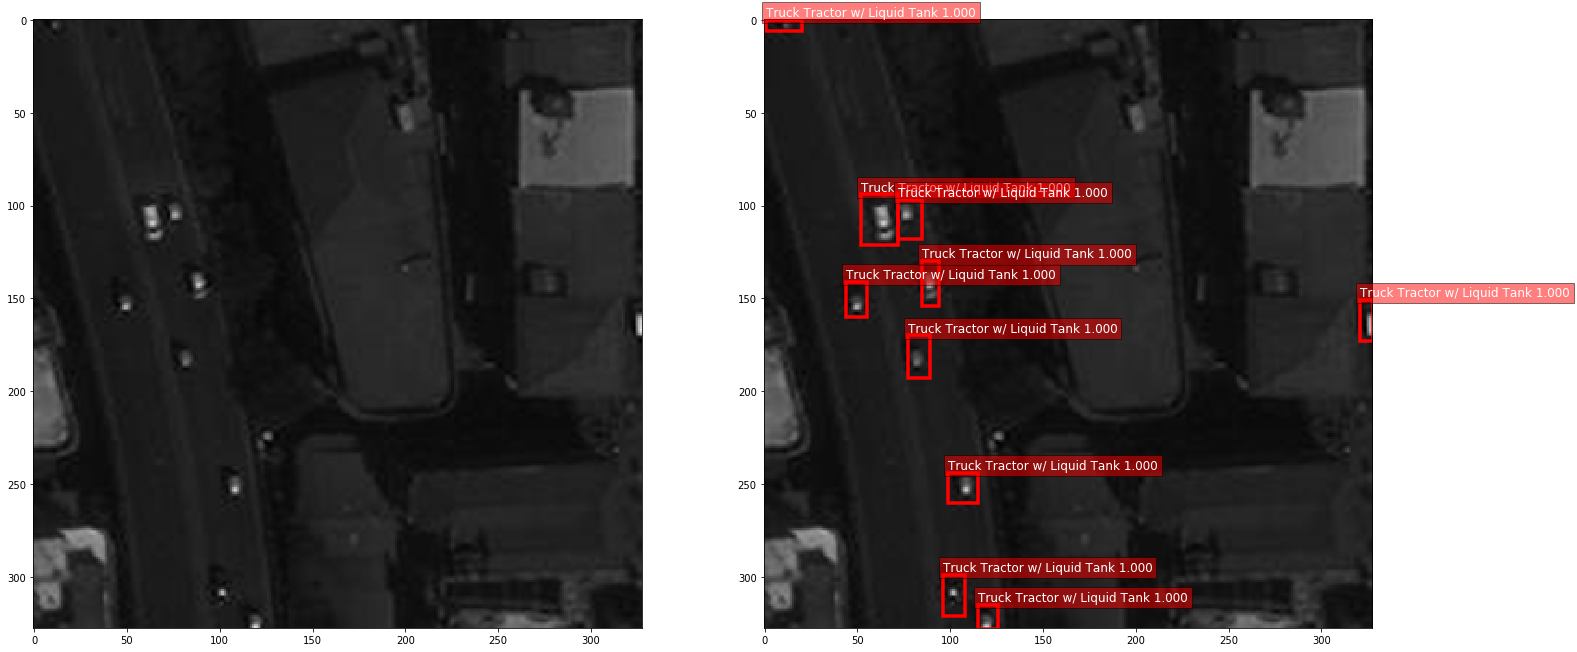

In [17]:
#Now we will provide our image to the endpoint.
x, image = gcv.data.transforms.presets.yolo.load_test('./data/test.jpg', short=328)
import matplotlib.pyplot as plt
lbls = gcv.data.transforms.bbox.resize(np.load('./data/test-lbls.npy'),(208,208),(328,328))


fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(1,2,1)
gcv.utils.viz.plot_bbox(image, bboxes, scores, ids, class_names=classes,ax=ax)
ax1 = fig.add_subplot(1,2,2)
gcv.utils.viz.plot_bbox(image, lbls[:,:-1], lbls[:,-1], class_names=classes,ax=ax1)